In this notebook we combine our dataset with the datasets from refine.bio. We look at BA46 and NUcleus Accumbens. We do PCA before and after batch effect removal.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Read the data

In [4]:
reference_distr = pd.read_csv("../data/refine.bio/reference_distr.tsv", sep="\t", header=None).values.reshape(-1,)

PATH = "../data/refine.bio/"
microarray = pd.read_csv(PATH + "microarray.csv", index_col=0)
rnaseq = pd.read_csv(PATH + "rnaseq.csv", index_col=0)

our_control_processed = pd.read_csv("../data/intermediate/control_lengthScaledTPM_normalized.csv", index_col=0).T
our_sz_processed = pd.read_csv("../data/intermediate/sz_lengthScaledTPM_normalized.csv", index_col=0).T

In [5]:
common_genes = list(set(our_control_processed.columns) & set(our_sz_processed) & set(microarray.columns) & set(rnaseq.columns))
len(set(our_control_processed.columns) & set(our_sz_processed)), len(set(microarray.columns) & set(rnaseq.columns)), len(common_genes)

(19836, 19482, 16191)

In [6]:
microarray = microarray[microarray.columns[:3].tolist() + common_genes]

rnaseq = rnaseq[rnaseq.columns[:3].tolist() + common_genes]

our_control_processed = our_control_processed[common_genes]
our_sz_processed = our_sz_processed[common_genes]

<AxesSubplot:ylabel='Density'>

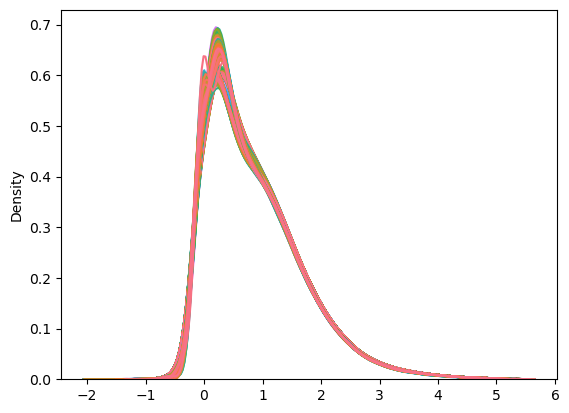

In [7]:
sns.kdeplot(np.log1p(rnaseq.T.iloc[3:].values.astype(float)), common_norm=False, legend=False)
sns.kdeplot(np.log1p(microarray.T.iloc[3:].values.astype(float)), common_norm=False, legend=False)
sns.kdeplot(np.log1p(our_control_processed.T), common_norm=False, legend=False)
sns.kdeplot(np.log1p(our_sz_processed.T), common_norm=False, legend=False)

In [8]:
control_header = pd.read_csv("../data/ours_counts/h.gene.count.csv", nrows=0).columns[1:]
sz_header = pd.read_csv("../data/ours_counts/schizo_gene_count_matrix.csv", nrows=0).columns[1:]

In [9]:
sz_header

Index(['1_1', '1_15', '1_16', '1_17', '1_18', '1_27', '1_28', '1_29', '1_30',
       '1_31',
       ...
       '5_57', '5_58', '5_63', '5_64', '5_68', '5_69', '5_72', '5_73', '5_74',
       '5_75'],
      dtype='object', length=140)

In [10]:
control_header

Index(['HA11', 'HA12', 'HA14', 'HA15', 'HA16', 'HA18', 'HA19', 'HA21', 'HA23',
       'HA25',
       ...
       'HD52', 'HD56', 'HD58', 'HD62', 'HD66', 'HD67', 'HD7', 'HD71', 'HD72',
       'HD74'],
      dtype='object', length=140)

In [11]:
our_control_processed.insert(0, "human", control_header.str[:2])
our_control_processed.insert(1, "region", control_header.str[2:])
our_control_processed.insert(2, "is_control", 1)
our_sz_processed.insert(0, "human", "H" + sz_header.str[0])
our_sz_processed.insert(1, "region", sz_header.str[2:])
our_sz_processed.insert(2, "is_control", 0)

# Comparison

## PCA for BA46

We compare microarray and RNA-seq technology here. This is much less meaningful than comparing RNA-seq and RNA-seq.

In [12]:
theirs_ba = microarray[microarray.region == "BA46"]
ours_ba = pd.concat(
    [our_control_processed[our_control_processed.region == "34"], our_sz_processed[our_sz_processed.region == "34"]]
)

In [13]:
pca = PCA(n_components=2)

A = np.log1p(ours_ba.iloc[:, 3:])
B = np.log1p(theirs_ba.iloc[:, 3:])

data_pca = pca.fit_transform(pd.concat([A, B]).values)

In [14]:
# list(zip(range(8, 89 + 8), theirs_ba.human.tolist()))

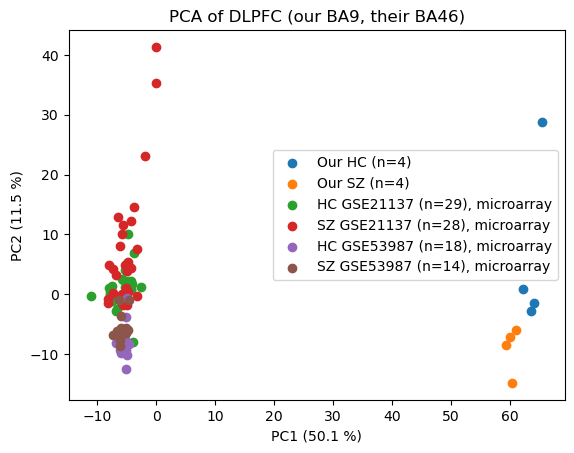

In [15]:
plt.scatter(data_pca[:4, 0], data_pca[:4, 1], label="Our HC (n=4)")
plt.scatter(data_pca[4:8, 0], data_pca[4:8, 1], label="Our SZ (n=4)")

plt.scatter(data_pca[8:37, 0], data_pca[8:37, 1], label="HC GSE21137 (n=29), microarray")
plt.scatter(data_pca[37:65, 0], data_pca[37:65, 1], label="SZ GSE21137 (n=28), microarray")

plt.scatter(data_pca[65:83, 0], data_pca[65:83, 1], label="HC GSE53987 (n=18), microarray")
plt.scatter(data_pca[83:97, 0], data_pca[83:97, 1], label="SZ GSE53987 (n=14), microarray")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100 :.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100 :.1f} %)")
plt.title("PCA of DLPFC (our BA9, their BA46)")
plt.legend()

A strong batch effect is present.

We have 3 batches here, strictly speaking (our, GSE21137 and GSE53987).

In [16]:
pd.concat([A, B]).T.to_csv("../data/intermediate/x.csv")
batch = np.zeros(A.shape[0] + B.shape[0])
batch[:A.shape[0]] = 1
pd.DataFrame(batch).to_csv("../data/intermediate/batch.csv")

pd.concat([1 - ours_ba.is_control, 1 - theirs_ba.is_control]).to_csv("../data/intermediate/design.csv")

At this point you must go to the 4_remove batch effect using Limma (R kernel).ipynb and launch it.

In [17]:
x_be_removed = pd.read_csv("../data/intermediate/x_be_removed.csv", index_col=0)

In [18]:
data_pca = pca.fit_transform(x_be_removed.T.values)

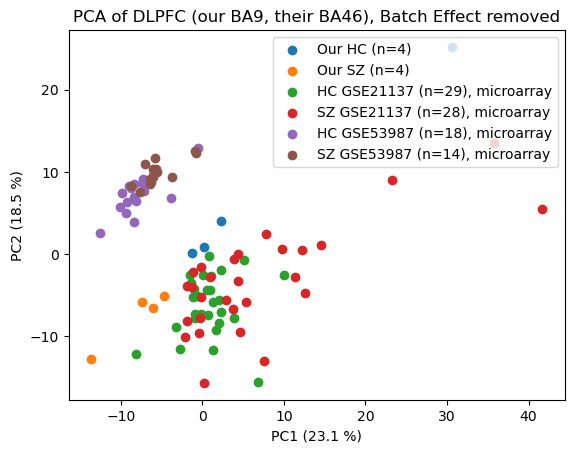

In [19]:
plt.scatter(data_pca[:4, 0], data_pca[:4, 1], label="Our HC (n=4)")
plt.scatter(data_pca[4:8, 0], data_pca[4:8, 1], label="Our SZ (n=4)")

plt.scatter(data_pca[8:37, 0], data_pca[8:37, 1], label="HC GSE21137 (n=29), microarray")
plt.scatter(data_pca[37:65, 0], data_pca[37:65, 1], label="SZ GSE21137 (n=28), microarray")

plt.scatter(data_pca[65:83, 0], data_pca[65:83, 1], label="HC GSE53987 (n=18), microarray")
plt.scatter(data_pca[83:97, 0], data_pca[83:97, 1], label="SZ GSE53987 (n=14), microarray")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100 :.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100 :.1f} %)")
plt.title("PCA of DLPFC (our BA9, their BA46), Batch Effect removed")
plt.legend()

## PCA for Nucleus Accumbens

First - control, then - SZ.

In [44]:
theirs_ba = rnaseq[rnaseq.region == "56 Nucleus Accumbens"]
theirs_ba = theirs_ba.sort_values(by="is_control", ascending=False)
ours_ba = pd.concat(
    [our_control_processed[our_control_processed.region == "56"], our_sz_processed[our_sz_processed.region == "56"]]
)

In [45]:
pca = PCA(n_components=2)
A = np.log1p(ours_ba.iloc[:, 3:])
B = np.log1p(theirs_ba.iloc[:, 3:])
data_pca = pca.fit_transform(pd.concat([A, B]).values)

In [46]:
theirs_n_control = theirs_ba.is_control.sum()
theirs_n_sz = theirs_ba.shape[0] - theirs_n_control

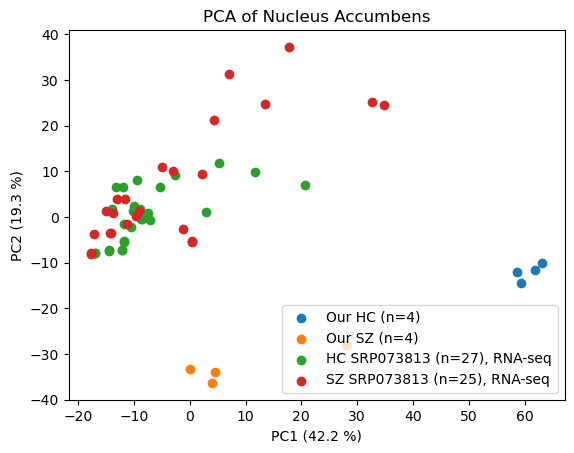

In [47]:
plt.scatter(data_pca[:4, 0], data_pca[:4, 1], label="Our HC (n=4)")
plt.scatter(data_pca[4:8, 0], data_pca[4:8, 1], label="Our SZ (n=4)")

plt.scatter(
    data_pca[8:8 + theirs_n_control, 0],
    data_pca[8:8 + theirs_n_control, 1],
    label=f"HC SRP073813 (n={theirs_n_control}), RNA-seq",
)
plt.scatter(
    data_pca[8 + theirs_n_control:, 0],
    data_pca[8 + theirs_n_control:, 1],
    label=f"SZ SRP073813 (n={theirs_n_sz}), RNA-seq"
)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100 :.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100 :.1f} %)")
plt.title("PCA of Nucleus Accumbens")
plt.legend()

In [48]:
pd.concat([A, B]).T.to_csv("../data/intermediate/x.csv")
batch = np.zeros(A.shape[0] + B.shape[0])
batch[:A.shape[0]] = 1
pd.DataFrame(batch).to_csv("../data/intermediate/batch.csv")

At this point you must go to the 4_remove batch effect using Limma (R kernel).ipynb and launch it.

In [49]:
x_be_removed = pd.read_csv("../data/intermediate/x_be_removed.csv", index_col=0)

In [50]:
data_pca = pca.fit_transform(x_be_removed.T.values)

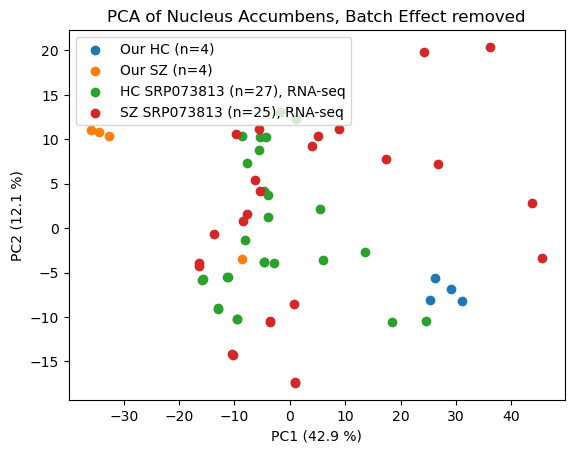

In [51]:
plt.scatter(data_pca[:4, 0], data_pca[:4, 1], label="Our HC (n=4)")
plt.scatter(data_pca[4:8, 0], data_pca[4:8, 1], label="Our SZ (n=4)")

plt.scatter(
    data_pca[8:8 + theirs_n_control, 0],
    data_pca[8:8 + theirs_n_control, 1],
    label=f"HC SRP073813 (n={theirs_n_control}), RNA-seq",
)
plt.scatter(
    data_pca[8 + theirs_n_control:, 0],
    data_pca[8 + theirs_n_control:, 1],
    label=f"SZ SRP073813 (n={theirs_n_sz}), RNA-seq"
)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100 :.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100 :.1f} %)")
plt.title("PCA of Nucleus Accumbens, Batch Effect removed")
plt.legend()